<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/8_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
#@title <b><font color="red">▶</font><font color="black"> run this cell and restart runtime</font></b>

!python -m spacy download en_core_web_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-27 07:30:24.281157: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [57]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.utils import (
    enable_mathjax_in_cell,
    display_pca_scatterplot,
    display_pca_scatterplot_interactive
)
from tmcourse.demo import (
    demo_word2vec_batch,
    demo_gradient_descent,
)
from tmcourse.quiz import (
    quiz_skibidi,
    quiz_word2vec_context,
    quiz_word2vec_word_vector,
    quiz_word2vec_subsampling,
    quiz_word2vec_negative_sampling,
    quiz_most_similar,
    quiz_earl,
)
from tmcourse.ipyquiz import Quiz
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 738 (delta 79), reused 158 (delta 69), pack-reused 563
Receiving objects: 100% (738/738), 179.50 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Updating files: 100% (129/129), done.


<!--@slideshow slide-->
<center><h1>Word vectors</h1></center>

<!--@slideshow slide-->
# Outline
1. Sparsity problem (words are not orthogonal)
1. Word meanings and distributional hypothesis
1. word2vec: idea and algorithm
1. Visualization of word vectors
1. Properties of word vectors
1. GloVe
1. FastText
1. Word vectors in spaCy

<!--@slideshow slide-->
# Sparsity problem (words are not orthogonal)

So far, we treated words (or terms) as discrete symbols.
  - For each word, `TfidfVectorizer` creates a separate vector component.
  - Hence all words are _orthogonal_.


<!--@slideshow fragment-->
The following experiment shows that it may be a problem:
1. Take two questions from the Quora Question Pairs dataset:
    - "How can I be a good geologist?"
    - "What should I do to be a great geologist?"
1. Compute the distance between their tfidf-vectors
1. Repeat with only one change in the second question: "good" instead of "great".

In [58]:
#@slideshow slide
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
def row_to_array(sparse_matrix_row):
    return np.squeeze(np.asarray(sparse_matrix_row.todense()))

df = pd.read_csv("harbour-space-text-mining-course/datasets/quora_question_pairs/train.csv")

# words 'good' and 'great' are similar, but have different TF-IDF representations
# let's see if it makes any difference

vec = TfidfVectorizer().fit(list(df["question1"].fillna(".")) + list(df["question2"].fillna(".")))

question_1 =              "How can I be a good geologist?"  # df.iloc[7]["question1"]
question_2 =              "What should I do to be a great geologist?"  # df.iloc[7]["question2"]
question_2_reformulated = "What should I do to be a good geologist?"

vector_1 = row_to_array(vec.transform([question_1]))
vector_2 = row_to_array(vec.transform([question_2]))
vector_2_reformulated = row_to_array(vec.transform([question_2_reformulated]))
print("cosine(\"{}\", \"{}\") = {:.2f}".format(question_1, question_2, cosine(vector_1, vector_2)))
print("cosine(\"{}\", \"{}\") = {:.2f}".format(question_1, question_2_reformulated, cosine(vector_1, vector_2_reformulated)))

cosine("How can I be a good geologist?", "What should I do to be a great geologist?") = 0.24
cosine("How can I be a good geologist?", "What should I do to be a good geologist?") = 0.11


<!--@slideshow slide-->
Words "good" and "great" have similar meanings in this case, but for TF-IDF they are different.

<!--@slideshow fragment-->
**Our goal**: instead of discrete representations (all words are different, or orthogonal), find representations that captures similarity between words.


<!--@slideshow fragment-->
**Technically**, we will represent words as _vectors_ such that the words with similar meanings will have similar (close) vectors.


<!--@slideshow fragment-->
But, what is "meaning"? How do **we** understand the meaning of the word?

<!--@slideshow slide-->
# Word meanings. Distributional hypothesis.

<!--@slideshow slide-->
## Colab quiz 1
What is "skibidi"?

In [59]:
quiz_skibidi()()

<!--@slideshow fragment-->
Actually, neither the word "skibidi" nor the definitions 1-4 exist.
This quiz was generated using https://www.thisworddoesnotexist.com/

How did you know the meaning of "skibidi"?

<!--@slideshow slide-->
## Distributional semantics
**Idea**: the meaning of a word can be deduced from  _contexts_ the word appears in.

> "You shall know a word by the company it keeps" (Firth, 1957)

<!--@slideshow slide-->
- **What we need**: represent words by vectors such that words with similar meanings have similar vectors.
- **What we know (assume)**: the meaning of a word can be deduced from  _contexts_ the word appears in
- **What we will do**: given a word, predict its context.

<!--@slideshow slide-->
# word2vec


<!--@slideshow slide-->
**Idea**: for each word, find a vector such that words with similar vectors often occur in the same context.


<!--@slideshow fragment-->
- A large corpus of text (Wikipedia).
- Every word is represented by a vector.
- For each position in the text:
  1. Get the word on this position.
  1. Get the context of the word.
  1. Adjust vectors to maximize the probability of the observed context (the closer the vectors, the larger the probability).

<!--@slideshow slide-->
## Colab demo: word2vec context

By definition, the context consists of $m$ surrounding words on the left and $m$ on the right. See the demonstration for $m=3$.

In [60]:
demo_word2vec_batch("never gonna give you up never gonna let you down".split(), 3)

<!--@slideshow slide-->
## Colab quiz 2
Choose the correct context

In [61]:
quiz_word2vec_context()()

<!--@slideshow slide-->
## word2vec: objective function

Consider the position $t$ in the text:
- Word: $w_t$
- Context: $$w_{t-m}, w_{t-m + 1}, \dots, w_{\color{red}{t-1}}, w_{\color{red}{t+1}}, \dots, w_{t+m-1}, w_{t+m}$$
- Probability of the context
$$
\Pr(w_{t-m}, w_{t-m + 1}, \dots, w_{t-1}, w_{t+1}, \dots, w_{t+m-1}, w_{t+m}|w_t) \equiv \Pr_{\textrm{context}}(t)
$$
- Likelihood of the corpus is:
$$
\prod_{t=1}^T \Pr_{\textrm{context}}(t)
$$

<!--@slideshow slide-->

Word vectors are _parameters_ $\theta$.

**Our goal**: maximize the likelihood, or minimize the _negative log-likelihood_ w.r.t. $\theta$:
$$
L(\theta) = -\sum_{t=1}^T \log\Pr_{\textrm{context}}(t)
$$

<!--@slideshow fragment-->
**Assumption**: for each $t$, words both inside and outside the context are conditionally independent given $w_t$.

> Informally, for any word $\hat{w}$, the probability to find $\hat{w}$ in the context of $w_t$ depends only on $w_t$.


<!--@slideshow fragment-->
So we can write:
$$
\Pr_{\textrm{context}}(t) = \left(\prod_{w' \in \textrm{context}(w_t)} \Pr(w'|w_t)\right)\left(\prod_{w'' \notin \textrm{context}(w_t)}(1 - \Pr(w''|w))\right)
$$

<!--@slideshow slide-->
The objective function:
$$
L(\theta) = -\sum_{t=1}^T \left(\sum_{w' \in \textrm{context}(w_t)} \log\Pr(w'|w_t) + \sum_{w'' \notin \textrm{context}(w_t)}\log(1 - \Pr(w''|w))\right)
$$

As usual, we will use gradient descent to find parameters (word vectors) $\theta$ that minimize $L(\theta)$. 

<!--@slideshow slide-->
## Problem 1: word in its own context

How do we estimate $\Pr(o|c)$?

Suppose the word $o$ has vector $\mathbf{u}$, and the word $c$ has vector $\mathbf{v}$.

It's natural to estimate
$$
\Pr(o|c) = \sigma(\mathbf{u} \cdot \mathbf{v})
$$
where $\mathbf{u} \cdot \mathbf{v}$ is the dot product, and $\sigma(s) = \dfrac{1}{1 + e^{-s}}$ is the sigmoid function.

<!--@slideshow fragment-->
But what if $o = c$?

The dot product is large, but the probability to see the word in its own context is low!

<!--@slideshow fragment-->
**Solution**: for each word $w$, instead of _one_ vector, keep _two_ vectors:
1. When $w$ is the context word: $\mathbf{u}_w$.
1. When $w$ is the central word: $\mathbf{v}_w$.

<!--@slideshow slide-->
## Problem 2: computational complexity
Remember that the objective function is
$$
L(\theta) = -\sum_{t=1}^T \left(\sum_{w' \in \textrm{context}(w_t)} \log\Pr(w'|w_t) + \sum_{\color{red}{w'' \notin \textrm{context}(w_t)}}\log(1 - \Pr(w''|w))\right)
$$


<!--@slideshow fragment-->
- In each term, the second sum is computed over the full vocabulary (except for the context of $w_t$).
- We need to compute it for each position $t$ in the text.


<!--@slideshow fragment-->
**Solution**: **for each context word**, keep only the fixed number (5-20) of terms in the second sum.

> This is called **negative sampling**.

<!--@slideshow slide-->
## Problem 3: "meaningless" words

Some words (like prepositions and articles in English)
- are very frequent,
- play only a technical role and therefore don't have meaning.



<!--@slideshow fragment-->
So they harm the performance of stochastic gradient descent, because
- they cause may updates because they are frequent,
- these updates are "noisy", because "technical" words don't have meaning.

<!--@slideshow fragment-->
**Solution**: throw frequent words away with some probability (the higher the frequency, the higher the probability).

> This is called **subsampling**.

<!--@slideshow slide-->
## Colab demo: word2vec implementation

In [62]:
import numpy as np
from collections import Counter
from scipy.special import softmax
from scipy.special import expit as sigmoid  # "expit" is the inverse of "logit"
from scipy.spatial.distance import cosine as cosine_distance

class Word2Vec:
    """
    This is an instructive implementation of skip-gram word2vec algorithm with negative sampling loss.
    It is deliberately inefficient: it uses built-in Python data structures (dicts and lists)
    instead of matrix-vector operations.

    The recommended way to read the code is the following:
    1. First, read the implementation of the `train()` method:
        - Training loop: iterate few times (epochs) over the training data.
          Number of epochs is provided in the `n_epoch` parameter,
          and `self.learning_rate` is predefined step size of gradient descent.
        - In each iteration, a batch (central_word and context_words) is generated.
        - Too frequent words are discarded (subsampling).
        - The gradients are computed and gradient step is performed.
    2. Then look at the method `generate_batches()`.
       It creates pairs (central word, [list of context words])
       by moving sliding window of predefined size `self.window_size`.
    3. Then check the `generate_negative_samples()` method.
       Its implementation is short, but there are two important details:
       - Sampling is performed with replacement. It mimics i.i.d. assumption:
         negative samples must be independent.
       - The central word and the context word are discarded from the set 
         of negative samples.
    4. The most important part is how gradients are computed: the method `compute_gradients()`.
       The gradients are derived in this lecture; this method just implements them in Python code.
    5. Then take a look at `build_vocabulary()`: it is mostly technical.
    6. `get_vector()` method is just a one-liner, but pay attention to the fact
       that we use only one of two matrices (the matrix of central vectors).
    7. `get_similar_words()` method implements inefficient (O(|V|)) search of
       words whose vectors are closest to the vector of the given word.
    8. `__init__()` method just stores all hyperparameters and initializes necessary data structures.
    """
    def __init__(
        self,
        window_size=2,
        vector_size=10,
        n_negative_samples=20,
        learning_rate=1e-5,
        seed=0
    ):
        self.window_size = window_size
        self.learning_rate = learning_rate

        self.vocab = Counter()

        # how many dimensions each vector has
        self.vector_size = vector_size
        # vectors are initialized in .build_vocabulary() after the vocabulary is known
        self.central_vectors = dict()  
        self.context_vectors = dict()

        # number of negative samples for each context word
        self.n_negative_samples = n_negative_samples

        # prepare vocabulary for negative sampling and subsampling
        self.words_array = []
        self.negative_sampling_probabilities = []
        self.subsampling_probabilities = dict()

        np.random.seed(seed)

    def build_vocabulary(self, sequences):
        # count all the words
        for sequence in sequences:
            for word in sequence:
                self.vocab[word] += 1

        sum_counts_negative_sampling = sum(v**0.75 for v in self.vocab.values())
        sum_counts_subsampling = sum(self.vocab.values())
        for word, count in self.vocab.items():
            self.words_array.append(word)
            self.negative_sampling_probabilities.append(count**0.75 / sum_counts_negative_sampling)
            word_frequency = count / sum_counts_subsampling
            self.subsampling_probabilities[word] = (1 + np.sqrt(word_frequency / 0.001)) * 0.001 / word_frequency

        # initialize vectors with small values around 0
        for word in self.vocab:
            self.central_vectors[word] = np.random.randn(self.vector_size) * 0.1
            self.context_vectors[word] = np.random.randn(self.vector_size) * 0.1

    def generate_batches(self, sequence):
        # move sliding window over the sequence 
        # for each position of the window generate list of context words
        # return list of lists pairs (central word, [context words])
        batches = []
        for i_central, central_word in enumerate(sequence):
            # ignore the words outside of vocabulary (we don't have vectors for them)
            if central_word not in self.vocab:
                continue
            context_words = []
            # iterate from i_central - window_size, i_central + window_size
            for i_context in range(i_central - self.window_size, i_central + self.window_size + 1):
                # handle boundary cases
                if i_context < 0 or i_context >= len(sequence):
                    continue
                # exclude the central word itself
                if i_context == i_central:
                    continue
                context_word = sequence[i_context]
                # ignore the words outside of vocabulary
                if context_word not in self.vocab:
                    continue
                # update the batch that corresponds to the current central word
                context_words.append(context_word)
            # update batches with the collected batch
            batches.append((central_word, context_words))
        return batches

    def generate_negative_samples(self, central_word, context_word):
        negative_samples = np.random.choice(
            self.words_array,
            size=self.n_negative_samples,
            replace=True,  # sampling with replacement: mimics i.i.d assumption
            p=self.negative_sampling_probabilities
        )
        return [n for n in negative_samples if n != central_word and n != context_word]

    def compute_gradients(self, central_word, context_word, negative_samples):
        central_vector = self.central_vectors[central_word]

        # accumulate gradient of the central word
        central_word_gradient = np.zeros(self.vector_size)

        context_word_vector = self.context_vectors[context_word]
        context_words_gradient = -central_vector * (1 - sigmoid(np.dot(context_word_vector, central_vector)))

        central_word_gradient += -context_word_vector * (1 - sigmoid(np.dot(context_word_vector, central_vector)))

        # a word in negative sample can be sampled many times, so we accumulate gradients
        negative_samples_gradients = {n: np.zeros(self.vector_size) for n in negative_samples}
        for negative_sample in negative_samples:
            negative_sample_vector = self.context_vectors[negative_sample]
            negative_samples_gradients[negative_sample] += central_vector * (1 - sigmoid(-np.dot(negative_sample_vector, central_vector)))
            central_word_gradient += negative_sample_vector * (1 - sigmoid(-np.dot(negative_sample_vector, central_vector)))

        return central_word_gradient, context_words_gradient, negative_samples_gradients

    def train(self, sequences, n_epoch=5):
        T = 0
        for epoch in range(n_epoch):
            for sequence in sequences:
                # learning rate decays proportional to the number of iterations
                # similar to the original word2vec code
                alpha = self.learning_rate * max(0.0001, (1 - T / (n_epoch * len(sequences))))
                T += 1
                for batch in self.generate_batches(sequence):
                    central_word, context_words = batch

                    # subsample: randomly discard too frequent words
                    if np.random.random() > self.subsampling_probabilities[central_word]:
                        continue

                    for context_word in context_words:
                        # generate negative samples
                        # negative samples do not include the central word and the context word
                        negative_samples = self.generate_negative_samples(central_word, context_word)

                        # compute gradients
                        central_word_gradient, context_word_gradient, negative_samples_gradients = self.compute_gradients(
                            central_word, context_word, negative_samples
                        )
                        # perform one step of gradient descent: update all the parameters in direction opposite to gradient
                        self.central_vectors[central_word] -= alpha * central_word_gradient
                        self.context_vectors[context_word] -= alpha * context_word_gradient
                        for negative_sample in negative_samples:
                            self.context_vectors[negative_sample] -= alpha * negative_samples_gradients[negative_sample]

    def get_vector(self, word):
        return self.central_vectors[word]

    def get_similar_words(self, word, k=10):
        word_vector = self.get_vector(word)
        cosine_similarities = [1 - 0.5 * cosine_distance(word_vector, self.get_vector(w)) for w in self.words_array]
        return list(
            reversed([
                (self.words_array[i], cosine_similarities[i])
                for i in np.argsort(cosine_similarities)[-k-1:-1]  # exclude the word itself
            ])
        )


In [63]:
# toy example: "A" and "B" always occur near X
# all the other words (actually, characters) from the left and from the right are random
from string import ascii_lowercase
import random
from pprint import pprint

random.seed(0)
n_examples = 1000
# generate random left and right halves
left_contexts = [random.choices(ascii_lowercase, k=5) for _ in range(n_examples)]
right_contexts = [random.choices(ascii_lowercase, k=5) for _ in range(n_examples)]

# insert "XA" and "XB" to the middle
toy_dataset = [
    l + list("XA") + r for l, r in zip(left_contexts, right_contexts)
] + [
    l + list("XB") + r for l, r in zip(left_contexts, right_contexts)
]
random.shuffle(toy_dataset)

print("A few lines of the toy dataset:")
print("\n".join(["".join(t) for t in toy_dataset[:3]]))
window_size = 1
vector_size = 2
learning_rate = 0.1
n_epoch = 5
n_negative_samples = 5
word2vec = Word2Vec(
    seed=1,
    window_size=window_size,
    vector_size=vector_size,
    learning_rate=learning_rate,
    n_negative_samples=n_negative_samples
)
word2vec.build_vocabulary(toy_dataset)
word2vec.train(toy_dataset, n_epoch=n_epoch)
print("Words most similar to 'A'")
pprint(word2vec.get_similar_words("A"))

A few lines of the toy dataset:
vohgkXAyfvap
lgenmXAfojrf
lpkohXBwinqm
Words most similar to 'A'
[('B', 0.9999876210481137),
 ('z', 0.957950766495169),
 ('a', 0.9129377419737474),
 ('k', 0.9053724127989855),
 ('i', 0.903494187003081),
 ('b', 0.8990275152337034),
 ('n', 0.8655117493755607),
 ('g', 0.8500906263010772),
 ('t', 0.8474761246122444),
 ('m', 0.8428073281604462)]


<!--@slideshow slide-->
## Colab quiz 3

How are word vectors computed?

In [64]:
quiz_word2vec_word_vector()()

<!--@slideshow slide-->
## Colab quiz 4

Which words are subsampled?

In [65]:
quiz_word2vec_subsampling()()

<!--@slideshow slide-->
## Colab quiz 5

Details of negative sampling.

In [66]:
quiz_word2vec_negative_sampling()()

<!--@slideshow slide-->
## Derivation of gradients

<!--@slideshow slide-->
## Exercise 1
Prove that $\sigma(-\mathbf{x}) = 1 - \sigma(\mathbf{x})$.

<!--@slideshow slide-->
## Exercise 2

Prove that $\dfrac{\mathrm{d}\sigma(\mathbf{x})}{\mathrm{d}\mathbf{x}} = \sigma(\mathbf{x})(1-\sigma(\mathbf{x}))$.

<!--@slideshow slide-->
## Exercise 3

Prove that for arbitrary vectors $\mathbf{x}, \mathbf{y}$
- $\dfrac{\mathrm{d}(\mathbf{x} \cdot \mathbf{y})}{\mathrm{d}\mathbf{x}} = \mathbf{y}$
- $\dfrac{\mathrm{d}(\mathbf{x} \cdot \mathbf{y})}{\mathrm{d}\mathbf{y}} = \mathbf{x}$

<!--@slideshow slide-->
### Derivation of gradient w.r.t. central word

Consider one term in the objective function:
$$
\ell(c, o, N) = -\log\Pr(o|c) - \sum_{n \in N}\log(1 - \Pr(n|c))
$$
where $c$ is the central word, $o$ is the context ("outside") word, $n \in N$ is a negative sample.

<!--@slideshow fragment-->
Since $\Pr(o|c) = \sigma(\mathbf{u}_o \cdot \mathbf{v}_c)$ and $1 - \Pr(n|c) = \sigma(-\mathbf{u}_n \cdot \mathbf{v}_c)$, we have
$$
\ell(c, o, N) = -\log\sigma(\mathbf{u}_o \cdot \mathbf{v}_c) - \sum_{n \in N}\log\sigma(-\mathbf{u}_n \cdot \mathbf{v}_c)
$$

<!--@slideshow slide-->
$$
-\dfrac{\mathrm{d}\log\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)}{\mathrm{d}\mathbf{v}_c} 
$$


<!--@slideshow fragment-->
$$
= - \dfrac{1}{\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)} \dfrac{\mathrm{d}\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)}{\mathrm{d}\mathbf{v}_c}
$$


<!--@slideshow fragment-->
$$
= - \dfrac{1}{\sigma(\mathbf{u}_o \cdot \mathbf{v}_c)} \sigma(\mathbf{u}_o \cdot \mathbf{v}_c) (1 - \sigma(\mathbf{u}_o \cdot \mathbf{v}_c)) \dfrac{\mathrm{d} \mathbf{u}_o \cdot \mathbf{v}_c}{\mathrm{d}\mathbf{v}_c}
$$


<!--@slideshow fragment-->
$$
= - (1 - \sigma(\mathbf{u}_o \cdot \mathbf{v}_c)) \mathbf{u}_o
$$

<!--@slideshow slide-->
Similarly,

$$
\dfrac{\mathrm{d}}{\mathrm{d}\mathbf{v}_c}\left(-\sum_{n \in N}\log\sigma(-\mathbf{u}_n \cdot \mathbf{v}_c)\right)
=
\sum_{n \in N} \mathbf{u}_n(1 - \sigma(-\mathbf{u}_n\cdot \mathbf{v}_c))
$$ 

<!--@slideshow slide-->
## Exercise 4
Find derivatives $\dfrac{\mathrm{d}\ell(c, o, N)}{\mathrm{d}\mathbf{u}_o}$ and $\dfrac{\mathrm{d}\ell(c, o, N)}{\mathrm{d}\mathbf{u}_n}$.

<!--@slideshow slide-->
# Colab demo: word2vec in gensim

## How to train

In [67]:
print("Words most similar to 'A' (gensim implementation)")
from gensim.models import Word2Vec

gensim_word2vec = Word2Vec(
    sg=1,  # skip-gram
    hs=0,  # negative sampling
    size=vector_size,
    window=window_size,
    alpha=learning_rate,
    negative=n_negative_samples
)
gensim_word2vec.build_vocab(toy_dataset)
gensim_word2vec.train(toy_dataset, total_examples=len(toy_dataset), epochs=n_epoch)
pprint(gensim_word2vec.wv.most_similar("A"))

Words most similar to 'A' (gensim implementation)
[('B', 0.9979004859924316),
 ('r', 0.7980645298957825),
 ('d', 0.7550197243690491),
 ('e', 0.7487218379974365),
 ('v', 0.7393407225608826),
 ('f', 0.6941909790039062),
 ('z', 0.6901156902313232),
 ('p', 0.6767732501029968),
 ('q', 0.6506662368774414),
 ('j', 0.6409609913825989)]


In [68]:
# try the real dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(
    subset="all",
    shuffle=True,
    random_state=1,
    remove=('headers', 'footers', 'quotes')
)

from tqdm.notebook import tqdm
import spacy

# extract tokens (lemmas) with spaCy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner', 'tagger', 'tok2vec'])
def tokens(s):
    return [t.lemma_ for t in nlp(s)]

texts = [tokens(text) for text in tqdm(dataset.data, desc="tokenize")]

tokenize:   0%|          | 0/18846 [00:00<?, ?it/s]

In [69]:
# initialize, build vocabulary and train at once
gensim_word2vec = Word2Vec(
    texts,
    sg=1,  # skip-gram
    hs=0,  # negative sampling
    size=32,
    window=5,  # context is a 5-word window around the target word
    min_count=5  # ignore words that occur less than 5 times
).wv  # "wv" stands for "word vectors"

In [70]:
gensim_word2vec.most_similar("space")

[('planetary', 0.8659758567810059),
 ('exploration', 0.8650424480438232),
 ('hubble', 0.8597362041473389),
 ('shuttle', 0.8581129312515259),
 ('schedules', 0.8565541505813599),
 ('manned', 0.8454277515411377),
 ('nasa', 0.8419719934463501),
 ('missions', 0.8294183015823364),
 ('investor', 0.8272771835327148),
 ('ssf', 0.8271588683128357)]

In [71]:
gensim_word2vec.most_similar("gif")

[('images', 0.9353200197219849),
 ('jpeg', 0.9249697327613831),
 ('tiff', 0.9147523045539856),
 ('gifs', 0.8970943093299866),
 ('viewer', 0.8958752751350403),
 ('viewing', 0.8911834359169006),
 ('targa', 0.8879003524780273),
 ('bmp', 0.8820237517356873),
 ('pcx', 0.868255615234375),
 ('ppm', 0.8660796284675598)]

In [72]:
gensim_word2vec.most_similar("hockey")

[('nhl', 0.9141407012939453),
 ('regulars', 0.9000725746154785),
 ('baseball', 0.8906190395355225),
 ('basketball', 0.8836904764175415),
 ('league', 0.8729032278060913),
 ('champions', 0.8671470284461975),
 ('tournament', 0.860136091709137),
 ('espn', 0.8469244241714478),
 ('mlb', 0.8414235711097717),
 ('finals', 0.8407819867134094)]

## Pre-trained vectors

In [73]:
import gensim.downloader as api

# list all available models
from tabulate import tabulate
from IPython.display import display, HTML
all_gensim_models = api.info()["models"]
gensim_model_description = [(m, all_gensim_models[m]["description"]) for m in all_gensim_models]
display(HTML(tabulate(gensim_model_description, headers=("model name", "description"), tablefmt="html")))

model name,description
fasttext-wiki-news-subwords-300,"1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)."
conceptnet-numberbatch-17-06-300,"ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting."
word2vec-ruscorpora-300,Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words). The model contains 185K words.
word2vec-google-news-300,Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).
glove-wiki-gigaword-50,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-100,"Pre-trained vectors based on Wikipedia 2014 + Gigaword 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-200,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-300,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-25,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-50,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)"


In [74]:
# load a relatively small (128MB) model
model = api.load("glove-wiki-gigaword-100")

In [75]:
model.most_similar("twitter")

[('facebook', 0.9159134030342102),
 ('myspace', 0.838465690612793),
 ('youtube', 0.7946596741676331),
 ('blog', 0.7410155534744263),
 ('tweets', 0.726836085319519),
 ('tumblr', 0.7218027114868164),
 ('blogging', 0.7101112604141235),
 ('blogs', 0.6958351731300354),
 ('instagram', 0.6919254064559937),
 ('email', 0.6856087446212769)]

<!--@slideshow slide-->
## Colab quiz 6

What is the most similar to "twitter"?

In [76]:
quiz_most_similar()()

<!--@slideshow slide-->
# Visualization of word vectors

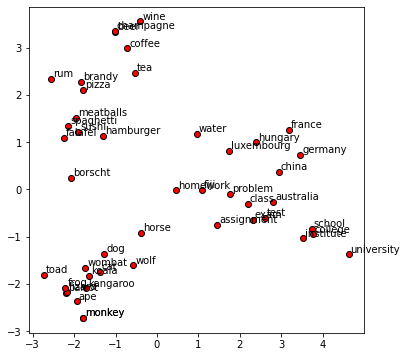

In [77]:
#@slideshow fragment tags=remove_input
display_pca_scatterplot(
    model,
    ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
    'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
    'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
    'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
    'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
    'homework', 'assignment', 'problem', 'exam', 'test', 'class',
    'school', 'college', 'university', 'institute',]
)

<!--@slideshow slide-->
# Properties of word vectors

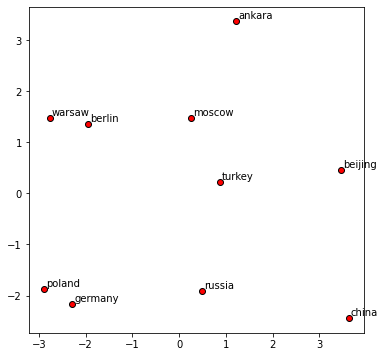

In [78]:
#@slideshow slide tags=remove_input
display_pca_scatterplot(
    model,
    [
        "china", "beijing",
        "russia", "moscow",
        "turkey", "ankara",
        "poland", "warsaw",
        "germany", "berlin",
    ]
)

<!--@slideshow fragment-->
For example, 
$$
\overrightarrow{\mathrm{Warsaw}} - \overrightarrow{\mathrm{Poland}} \approx  \overrightarrow{\mathrm{Moscow}} - \overrightarrow{\mathrm{Russia}}
$$
or, equivalently
$$
\overrightarrow{\mathrm{Warsaw}} - \overrightarrow{\mathrm{Poland}}  + \overrightarrow{\mathrm{Russia}} \approx \overrightarrow{\mathrm{Moscow}}
$$


Thus, word vectors represent some (but not all!) relations between words ("Warsaw is related to Poland in the same way as Moscow is related to Russia").

In [79]:
#@slideshow slide
from scipy.spatial.distance import cosine
print("Distance between <warsaw> and <moscow>:", cosine(model["warsaw"], model["moscow"]))
print("Distance between <poland> and <russia>:", cosine(model["poland"], model["russia"]))
print("Distance between <warsaw> - <poland> + <russia> and <moscow>:", cosine(model["warsaw"] - model["poland"] + model["russia"], model["moscow"]))

Distance between <warsaw> and <moscow>: 0.3461671471595764
Distance between <poland> and <russia>: 0.3346114158630371
Distance between <warsaw> - <poland> + <russia> and <moscow>: 0.13101792335510254


In [80]:
#@slideshow slide
def analogy(model, left_negative, left_positive, right_negative):
    """
    Solve the equation:
    left_positive - left_negative == X - right_negative
    X answers the question '`left_negative` to `left_positive` is `right_negative` to what?'
    """
    return model.most_similar(
        positive=[left_positive, right_negative],
        negative=[left_negative])[0][0]

# 'poland' is to 'warsaw' as 'russia' is to what?
analogy(model, "poland", "warsaw", "russia")

'moscow'

In [81]:
#@slideshow fragment
# expore other analogies
analogy(model, "germany", "beer", "france")

'wine'

In [82]:
#@slideshow fragment
# word vectors capture certain linguistic properties
analogy(model, "tall", "tallest", "long")

'longest'

<!--@slideshow slide-->
## Colab quiz 7

In [83]:
# earl - man = X - woman
enable_mathjax_in_cell()
quiz_earl()()

<!--@slideshow slide-->
# GloVe

<!--@slideshow fragment-->
**Question**: why do vectors represent relations?

<!--@slideshow fragment-->
**Insight**: _ratios_ of co-occurrence probabilities also give information - they encode meaningful componens.

<!--@slideshow slide-->
![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/ratios-1.png)

<!--@slideshow slide-->
![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/ratios-2.png)

<!--@slideshow slide-->

**Idea**: if we predict
$$
\log\Pr(o|c) = \mathbf{v}_o \cdot \mathbf{v}_c
$$
then _vector differences_ correspond to ratios of co-oсcurrence probabilities!
$$
\log\dfrac{\Pr(o|c_2)}{\Pr(o|c_1)} = \mathbf{v}_o \cdot (\mathbf{v}_{c_2} - \mathbf{v}_{c_1})
$$

<!--@slideshow slide-->
In our example:
$$
\log\dfrac{\Pr(o|\mathrm{ice})}{\Pr(o|\mathrm{steam})} = \mathbf{v}_o \cdot (\mathbf{v}_{\mathrm{ice}} - \mathbf{v}_{\mathrm{steam}})
$$

<!--@slideshow fragment-->
- $\mathbf{v}_\mathrm{solid} \cdot (\mathbf{v}_{\mathrm{ice}} - \mathbf{v}_{\mathrm{steam}}) = \log\dfrac{\Pr(\mathrm{solid}|\mathrm{ice})}{\Pr(\mathrm{solid}|\mathrm{steam})} = \log 8.9 \approx 2.19$
- $\mathbf{v}_\mathrm{gas} \cdot (\mathbf{v}_{\mathrm{ice}} - \mathbf{v}_{\mathrm{steam}}) = \log\dfrac{\Pr(\mathrm{gas}|\mathrm{ice})}{\Pr(\mathrm{gas}|\mathrm{steam})} = \log 8.5 \cdot 10^{-2} \approx -2.47$
- $\mathbf{v}_\mathrm{water} \cdot (\mathbf{v}_{\mathrm{ice}} - \mathbf{v}_{\mathrm{steam}}) = \log\dfrac{\Pr(\mathrm{water}|\mathrm{ice})}{\Pr(\mathrm{water}|\mathrm{steam})} = \log 1.36 \approx 0.31$
- $\mathbf{v}_\mathrm{fashion} \cdot (\mathbf{v}_{\mathrm{ice}} - \mathbf{v}_{\mathrm{steam}}) = \log\dfrac{\Pr(\mathrm{fashion}|\mathrm{ice})}{\Pr(\mathrm{fashion}|\mathrm{steam})} = \log 0.96 \approx -0.04$



<!--@slideshow fragment-->
**Interpretation**:

On the scale between "ice" and "steam",
- "solid" is closer to "ice"
- "gas" is closer to "steam"
- "water" is orthogonal (somewhere in between, related to both)
- "fashion" is orthogonal (unrelated)

<!--@slideshow slide-->

## GloVe: algorithm
Minimize:
$$
L(\theta) = \sum_{i \in V, j \in V, i \neq j} f(X_{ij}) \cdot (\mathbf{v}_i \cdot \tilde{\mathbf{v}}_j + b_i + \tilde{b}_j - \log X_{ij})^2
$$
where 
- $i, j$ -- words
- $X_{ij}$ -- how many times words $i$ and $j$ co-occur
- $\mathbf{v}_k, \tilde{\mathbf{v}}_k$ - word vectors of  $k$ (represent "meaning" of $k$)
- $ b_k, \tilde{b}_k$ -- bias terms of a word $k$ (helphul for training, represent frequency of $k$)
- $f(X_{ij})$ -- suppress rare (noisy) counters, helpful for training

![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/f.png)

<!--@slideshow slide-->
## GloVe: word vectors
$$
L(\theta) = \sum_{i \in V, j \in V, i \neq j} f(X_{ij}) \cdot (\mathbf{v}_i \cdot \tilde{\mathbf{v}}_j + b_i + \tilde{b}_j - \log X_{ij})^2
$$

Each word is represented by two vectors $\mathbf{v}, \tilde{\mathbf{v}}$, because
- We want to approximate $\mathbf{v}_i \cdot \tilde{\mathbf{v}}_j \approx \Pr(i|j)$.
- In general, $\Pr(i|j) \neq \Pr(j|i)$.

<!--@slideshow slide-->
## GloVe: bias terms
$$
L(\theta) = \sum_{i \in V, j \in V, i \neq j} f(X_{ij}) \cdot (\mathbf{v}_i \cdot \tilde{\mathbf{v}}_j + b_i + \tilde{b}_j - \log X_{ij})^2
$$

We want to approximate $\mathbf{v}_i \cdot \tilde{\mathbf{v}}_j \approx \log \Pr(i|j)$.

But the target (what we actually predict) is $\log X_{ij}$.


<!--@slideshow fragment-->
The "true" target could be estimated from counts
- $X_i$ - # of times word $i$ occurs
- $X_{ij}$ - # of times words $i,j$ co-occur

$$
\log \hat\Pr(i|j) = \log \frac{\hat\Pr(ij)}{\hat \Pr(i)} = \log \left[C \cdot \frac{X_{ij}}{X_i}\right] = \log X_{ij} - \log X_i + \mathrm{constant}
$$



<!--@slideshow fragment-->
$\log \hat\Pr(i|j)$ is noisy because of $X_i$ in the denominator, so we need smoothing, for example:
$$
\log \hat\Pr(i|j) = \log \left[C \cdot \frac{X_{ij}}{X_i \color{red}{+ \delta}}\right] = \log X_{ij} - \log [X_i\color{red}{+ \delta}] + \mathrm{constant}
$$



<!--@slideshow fragment-->
**Idea**: $X_{ij}$ contains all necessary information, learn everything else from data.

$$
b_i \approx - \log [X_i+ \delta] + \mathrm{constant}
$$

<!--@slideshow slide-->
# FastText

<!--@slideshow slide-->
## Word vectors with subword information

Sometimes we may guess (at least partially) the meaning of a word by looking at its pieces.


<!--@slideshow fragment-->
For example, for the word "sesquipedalophobia" we may guess it is a phobia (a fear of something).

<!--@slideshow fragment-->
(In case you are wondering, "sesquipedalophobia" is the fear of long words.)

<!--@slideshow fragment-->
**Idea**: learn not only word vectors, but also subword vectors.

<!--@slideshow slide-->
**Algorithm**:
- Represent each word as a collection of character $n$-gram.
- Include the word w itself in the set of its $n$-grams.
- Add special boundary symbols `<` and `>` at the beginning and end of words, allowing to distinguish prefixes and suffixes from other character sequences.
- Word vector is the sum of the vector representations of its $n$-grams.


<!--@slideshow fragment-->
**Example**: for $n=3$, the word "where" is represented as

  `<wh, whe, her, ere, re>, <where>`
    
> Note that the sequence `<her>`, corresponding to the word "her" is different from the trigram `her` from the word "where".

<!--@slideshow slide-->
## Colab demo: FastText (unsupervised)

In [84]:
!pip install -q fasttext

In [85]:
import fasttext

In [86]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset="all", shuffle=True, random_state=1, categories=("sci.space",), remove=('headers', 'footers', 'quotes'))

In [87]:
def prepare_text(t):
    import re
    s = " ".join(t.split()).lower()  # no newlines, lowercase
    return re.sub(r'[^\w\s]',' ',s)  # remove punctuation

In [88]:
# fasttest works with files in filesystem
with open("texts.txt", "w") as f:
    for t in dataset.data:
        f.write(prepare_text(t) + "\n")

In [89]:
!head texts.txt

re  space billboards even easier to implement than writing messages on the moon  once upon a time a group of space activists i belonged to in seattle considered a  goodyear blimp in orbit   the idea was to use a large structure that could carry an array of lights like the goodyear blimp has  placed in a low earth orbit of high inclination  it could eventually be seen by almost everyone on earth  only our collective disapproval of cluttering up space with such a thing stopped us from pursuing it  it had quite feasible economics  which i will not post here because i don t want to encourage the idea  if you want to do such a thing  go figure it out for yourself   dani eder
    how can you tell they re identical  you got one of them  star drek  the next syndication  neutrino scanners 
i had to turn to one of my problem sets that i did in class for this little problem  i don t have a calculator  but i do have the problem set that we did not too long ago  so i ll use that  and hope it s what

In [90]:
model = fasttext.train_unsupervised(
    input="texts.txt",
    epoch=10
)

In [91]:
model.get_nearest_neighbors("satellite")

[(0.9310543537139893, 'satellites'),
 (0.826610267162323, 'sat'),
 (0.7046252489089966, 'radar'),
 (0.684397280216217, 'iridium'),
 (0.6659807562828064, 'tracking'),
 (0.6609216928482056, 'telecommunications'),
 (0.6603425145149231, 'korean'),
 (0.656222939491272, 'intelsat'),
 (0.6515015959739685, 'european'),
 (0.6475222706794739, 'japan')]

In [92]:
model.get_nearest_neighbors("satelite")

[(0.965173065662384, 'satellite'),
 (0.8960800766944885, 'satellites'),
 (0.8491849303245544, 'sat'),
 (0.7472147345542908, 'items'),
 (0.7320234775543213, 'korean'),
 (0.723210334777832, 'radar'),
 (0.720881462097168, 'european'),
 (0.7101620435714722, 'iridium'),
 (0.709301233291626, 'olympus'),
 (0.7044820785522461, 'intelsat')]

<!--@slideshow slide-->
## Text classification

**Idea**: 
- Represent a text as the average of word vectors.
- Learn matrix $A$ such that $\mathrm{softmax}(A \cdot v)$ gives probability distribution over classes.
- Instead of the loss function for word2vec (negative log-likelihood), optimize the loss function for classification (cross-entropy).

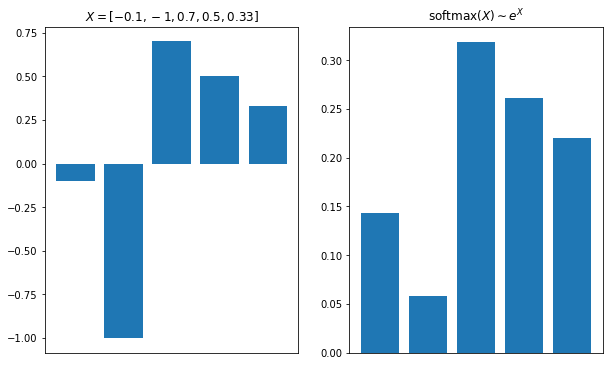

In [93]:
#@slideshow fragment tags=remove_input
import matplotlib.pyplot as plt
from scipy.special import softmax
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

x = [-0.1, -1, 0.7, 0.5, 0.33]
i = list(range(len(x)))
ax1.bar(i, x)
ax2.bar(i, softmax(x))
ax1.set_title(r"$X = {}$".format(x))
ax2.set_title(r"$\mathrm{softmax}(X) \sim e^X$")
ax1.set_xticks([])
ax2.set_xticks([])
plt.show()

<!--@slideshow slide-->
## Colab demo: FastText (supervised)

In [94]:
from sklearn.datasets import fetch_20newsgroups
fetch_params = dict(
    shuffle=True,
    random_state=1,
    remove=('headers', 'footers', 'quotes')
)
train_dataset = fetch_20newsgroups(subset="train", **fetch_params)
test_dataset = fetch_20newsgroups(subset="test", **fetch_params)

In [95]:
def convert_dataset_to_fasttext_file(texts, labels, path):
    with open(path, "w") as f:
        for t, l in zip(texts, labels):
            t = prepare_text(t)
            # labels are stored in file with prefix "__label__"
            f.write(f"__label__{l}\t{t}\n")

convert_dataset_to_fasttext_file(
    train_dataset.data,
    [train_dataset.target_names[c] for c in train_dataset.target],
    "train.txt"
)

In [96]:
!head -n1 train.txt

__label__talk.politics.mideast	well i m not sure about the story nad it did seem biased  what i disagree with is your statement that the u s  media is out to ruin israels reputation  that is rediculous  the u s  media is the most pro israeli media in the world  having lived in europe i realize that incidences such as the one described in the letter have occured  the u s  media as a whole seem to try to ignore them  the u s  is subsidizing israels existance and the europeans are not  at least not to the same degree   so i think that might be a reason they report more clearly on the atrocities  what is a shame is that in austria  daily reports of the inhuman acts commited by israeli soldiers and the blessing received from the government makes some of the holocaust guilt go away  after all  look how the jews are treating other races when they got power  it is unfortunate 


In [97]:
model = fasttext.train_supervised(
    input="train.txt",
    lr=0.1,
    epoch=25
)

In [98]:
total = 0
correct = 0
for t, c in zip(test_dataset.data, test_dataset.target):
    total += 1
    label = test_dataset.target_names[c]
    predicted_label = model.predict(prepare_text(t))[0][0][len("__label__"):]
    if label == predicted_label:
        correct += 1
print(f"accuracy: {correct / total}")

accuracy: 0.5762081784386617


<!--@slideshow slide-->
# Colab demo: word vectors in spaCy

In [99]:
import spacy
# spaCy is equipped by pre-trained word vectors
# for example, they are stored in "en_core_web_lg"
# in Colab, you need to run !python -m spacy download en_core_web_lg (the first cell) and restart runtime
nlp = spacy.load("en_core_web_lg", disable=["tagger", "ner", "parser"])

In [100]:
doc = nlp("dog cat banana afskfsd")

# you can check the attribute `.has_vector` of a token
for token in doc:
    print(f"Token '{token.text}' has a vector: {token.has_vector}")

# doc (parsed text, the collection of tokens) also has vector (the average over all tokens)
print(f"Doc has a vector: {doc.has_vector}")

Token 'dog' has a vector: True
Token 'cat' has a vector: True
Token 'banana' has a vector: True
Token 'afskfsd' has a vector: False
Doc has a vector: True


In [101]:
# for any pair of objects that have vectors, we can find similarity
# the example from the last lesson
doc1 = nlp("How can I be a good geologist?")
doc2 = nlp("What should I do to be a great geologist?")
doc3 = nlp("What should I do to be a good geologist?")
doc1.similarity(doc2), doc1.similarity(doc3)

(0.9265519131082379, 0.9298576579974973)

In [102]:
# in particular, any subsequence of a document (so-called Span) also may have a vector
# for example, a sentence in a document has vector (the average over all tokens of the sentence)
# to split the document into sentences, we need to add 'sentencizer' to NLP pipeline
nlp.add_pipe('sentencizer')

In [103]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(
    subset="all",
    shuffle=True,
    random_state=1,
    categories=("sci.space",),
    remove=('headers', 'footers', 'quotes')
)
from pprint import pprint

# after the sentenciser has been added, the parsed document contains `.sents` attribute:
for sentence in nlp(dataset.data[0]).sents:
    print("SENTENCE:\n", sentence)
    print("HAS VECTOR:", sentence.has_vector)
    print("---")

SENTENCE:
 Re: Space billboards

Even easier to implement than writing messages on the Moon, once upon
a time a group of space activists I belonged to in Seattle considered
a "Goodyear Blimp in orbit".
HAS VECTOR: True
---
SENTENCE:
  The idea was to use a large structure
that could carry an array of lights like the Goodyear Blimp has.
HAS VECTOR: True
---
SENTENCE:
 
Placed in a low Earth orbit of high inclination, it could eventually
be seen by almost everyone on Earth.
HAS VECTOR: True
---
SENTENCE:
  Only our collective disapproval
of cluttering up space with such a thing stopped us from pursuing
it.
HAS VECTOR: True
---
SENTENCE:
  It had quite feasible economics, which I will not post here
because I don't want to encourage the idea (if you want to do such
a thing, go figure it out for yourself).
HAS VECTOR: True
---
SENTENCE:
 

Dani Eder

HAS VECTOR: True
---


<!--@slideshow slide-->
# Summary
1. Words can be represented as non-orthogonal vectors.
1. The meaning of the word can be deduced from contexts the word appears in (distributional semantics).
1. word2vec
  - Find vectors such that words with similar vectors often occur in the same context.
  - Optimize log-likelihood using gradient descent.
  - Details: 2 vectors for each word, negative sampling, subsampling.
1. word2vec in gensim.
1. Word vectors capture relations between words.
1. GloVe: approximate co-occurrence probability
1. FastText: use subword information
1. Word vectors in spaCy

# Home Assignment 8

## Exercise 1 (6 points)

Use SpaCy vectors to solve Quora Question Pairs (like we did in the previous lecture with TD-IDF vectors).
You don't have to train vectors, the only thing you need is to apply spaCy vectors to the test dataset and compute similarities. The relevant code from the previous lecture is [here](https://colab.research.google.com/drive/1fq3Y-730mivy0halpGJhcq0nGEkOsYNP#scrollTo=n7A9Tq-47gcN&line=1&uniqifier=1).

Compare the results with TF-IDF. For TF-IDF vectors, we got the result ROC AUC = 0.719 on the test dataset .


In [111]:
# YOUR CODE HERE
import pandas as pd

df = pd.read_csv("harbour-space-text-mining-course/datasets/quora_question_pairs/train.csv")
print(f"Total samples: {df.shape[0]}")
df = df.head(20000)
df[["question1", "question2", "is_duplicate"]].head(10)


Total samples: 404290


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,How can I be a good geologist?,What should I do to be a great geologist?,1
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [138]:
import numpy as np
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df.fillna("."), test_size=0.5, shuffle=True, random_state=0)

In [139]:
similarities=[]
for i,j in df_test.iterrows():
  similarities.append(nlp(j['question1']).similarity(nlp(j['question2'])))

In [140]:
from sklearn.metrics import roc_auc_score
print("ROC AUC:", roc_auc_score(df_test.is_duplicate, similarities))

ROC AUC: 0.6513046758531265


**Using similar data as exercise 7(50% test) we get 0.65 ROC AUC score which is lower than TFIDF vectorizer.**

<!--@slideshow slide-->
# In-class coding session

Build news summarizer using word2vec.

Try the following idea:
1. Assume that there is a "central" vector (the main idea) of the article which is the average vector of all tokens in the article.
1. Find $k$ sentences closest to the "central" vector. The assumption is that these sentences are "informative", and other sentences are "noisy" and not important. To extract sentences (and their vectors), use `nlp.add_pipe('sentencizer')` and `doc.sents` property.

The function `parse_techcrunch_url(url)` parses the content from [techcrunch.com](https://techcrunch.com), you can use it to check your implementation on real data.

To estimate similarity, use `doc.similarity(sentence)` (or vise versa).

Also, implement a random baseline (get $k$ random sentences from the text) and compare the results (visually).

In [105]:
def parse_techcrunch_url(url):
    import bs4
    import re
    import requests
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.text, "html.parser")
    items = soup.find("div", {"class": "article-content"}).findAll("p")
    raw_html = "\n".join(map(str, items))
    cleanr = re.compile('<.*?>')
    clean_html = re.sub(cleanr, '', raw_html)
    return clean_html

from pprint import pprint
url = "https://techcrunch.com/2020/05/23/hackers-iphone-new-jailbreak/"
url = "https://techcrunch.com/2023/01/17/discord-acquires-gas-a-compliments-based-social-media-app-for-teens/"
pprint(parse_techcrunch_url(url))

('The messaging platform Discord announced its acquisition of Gas, an app '
 'that’s popular among teens for its positive spin on social media.\n'
 'On Gas, users sign up with their school, add friends and answer polls about '
 'their classmates. But the questions in the polls are intended to boost '
 'users’ confidence rather than damage it. Teens might be asked to choose '
 'which of four friends is the best DJ or has the best smile. Then the person '
 'who was chosen will get an anonymous message with their compliment, sent '
 'from a vague “boy in 10th grade” or “girl in 11th grade.”\n'
 'Gas was founded by Nikita Bier, who previously sold a similar app called tbh '
 'to Facebook in 2017 — tbh has since been shut down.\n'
 'According to data from Sensor Tower, Gas reached 7.4 million installs and '
 'almost $7 million in consumer spending since its launch in summer 2022. '
 'Users can subscribe to a paid feature called “God Mode,” which gives users '
 'hints about who their secret 

In [106]:
text = parse_techcrunch_url("https://techcrunch.com/2020/05/23/hackers-iphone-new-jailbreak/")

nlp = spacy.load("en_core_web_lg", disable=["tagger", "ner", "parser"])
nlp.add_pipe('sentencizer')

In [107]:
def summarize(text, k=5):
    # parse the input
    doc = nlp(text)
    sentence_data = []
    for i, sentence in enumerate(doc.sents):
        sentence_data.append((i, sentence.text, doc.similarity(sentence)))
    # get top closest sentences
    top_sentences = list(sorted(sentence_data, key=lambda x: -x[2]))[:k]
    top_sentences.sort(key=lambda x: x[0])

    return " ".join([x[1] for x in top_sentences])

pprint(summarize(text))

('Hackers do this by finding a previously undisclosed vulnerability in iOS '
 'that break through some of the many restrictions that Apple puts in place to '
 'prevent access to the underlying software. But jailbreakers say breaking '
 'through those restrictions allows them to customize their iPhones more than '
 'they would otherwise, in a way that most Android users are already '
 'accustomed to. \n'
 'Details of the vulnerability that the hackers used to build the jailbreak '
 'aren’t known, but it’s not expected to last forever. Just as jailbreakers '
 'work to find a way in, Apple works fast to patch the flaws and close the '
 'jailbreak. \n'
 'Security experts typically advise iPhone users against jailbreaking, because '
 'breaking out of the “walled garden” vastly increases the surface area for '
 'new vulnerabilities to exist and to be found.')


<!--@slideshow slide-->
# Recommended resources
- [📖 Distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics)
- [📖 YDSA NLP course, lecture 1](https://github.com/yandexdataschool/nlp_course/tree/2019/week01_embeddings)
- Stanford CS224n, lecture 1
  - [📺 video](https://www.youtube.com/watch?v=8rXD5-xhemo&feature=youtu.be)
  - [📖 slides](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/slides/cs224n-2019-lecture01-wordvecs1.pdf)
  - [📖 notes](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/readings/cs224n-2019-notes01-wordvecs1.pdf)
- [📖 The original word2vec code](https://code.google.com/archive/p/word2vec/)
- FastText
  - [Documentation](https://fasttext.cc/)
  - [Paper "Enriching Word Vectors with Subword Information"](https://arxiv.org/abs/1607.04606)
  - [Paper "Bag of Tricks for Efficient Text Classification"](https://arxiv.org/abs/1607.01759)
- [vectors in spaCy](https://spacy.io/usage/vectors-similarity)

# [OPTIONAL] Principal Component Analysis (PCA)

The illustration of the Principal Component Analysis. In case of 2 dimensions, PCA can be understood as the best projection of 2-dimensional data into a straingt line.

(-6.501071474160739, 6.877616311403686, -12.01989936222766, 10.706263560914952)

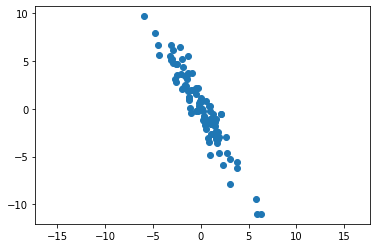

In [108]:
# project 2-dimensional ellipsoid onto a 1-dimensional line
# in other words: explain each point with a single number
def rotation_matrix(radians):
    c, s = np.cos(radians), np.sin(radians)
    return np.matrix([[c, s], [-s, c]])

def generate_cloud(size, var1, var2, radians):
    import numpy as np
    j = rotation_matrix(radians)
    return np.asarray(np.random.multivariate_normal([0., 0.], [[var1, 0], [0, var2]], size=size) @ j)

cloud = generate_cloud(100, 0.5, 20, 0.5)
import matplotlib.pyplot as plt

plt.scatter(cloud[:, 0], cloud[:, 1])
plt.axis("equal")

(-12.525150925830724,
 13.846057843408872,
 -1.8395641594815182,
 1.8529875886678913)

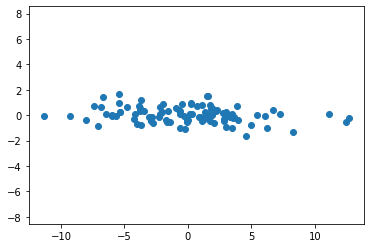

In [109]:
# find the rotation angle via slope
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(cloud[:, 0].reshape(-1, 1), cloud[:, 1])
# clf.coef_ is the slope = tan(rotation angles)
# rotate back
angle_to_rotate = -np.arctan(clf.coef_).item()
rotated_cloud = np.asarray(cloud @ rotation_matrix(angle_to_rotate))
plt.scatter(
    rotated_cloud[:, 0],  # the first principal component
    rotated_cloud[:, 1]
)
plt.axis("equal")

(-12.353731513739344,
 14.007788256632987,
 -1.6862173835975365,
 1.7064803806761493)

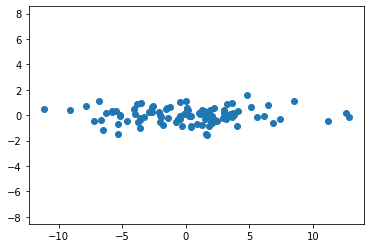

In [110]:
from sklearn.decomposition import PCA
trf = PCA()
result = trf.fit_transform(cloud)

plt.scatter(result[:, 0], result[:, 1])
plt.axis("equal")